In [39]:
import tweepy 
import pickle
import os
import sys
from datetime import datetime
import time
import operator
from datetime import datetime, timedelta
import json
from pprint import pprint 
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import copy
from collections import Counter
import urllib.request
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [32]:
#parameters:

#Minimum number of tweets for a user to be considered
min_status_count = 100

#A folder to store data of all collected user accounts
TWEETS_FOLDER = 'MetaFiles/Tweets/'

#A folder to store data of all the identified immigrants
IMMIGRANTS_FOLDER = 'MetaFiles/Immigrants/'

#A folder to store feature objects of the immigrants
IMMIGRANTS_FEATURES_FOLDER = 'MetaFiles/ImmigrantsFeatures/'

#A folder to store feature objects of the non-immigrants
NON_IMMIGRANTS_FEATURES_FOLDER = 'MetaFiles/NonImmigrantsFeatures/'

#A file to store a similar account from non-immigrants for every immigrants (used in diff in diff)
SIMILARS_FILE = 'MetaFiles/similars.csv'

# A folder to store the object of immigrants
IMMIGRANTS_OBJECTS = 'MetaFiles/ImmigrantsObjects/'

#Training file address:
TRAINING_FILE = 'MetaFiles/3K_labeled'

#A folder to store the probability of the tweets for every user in individual files
PROBS_FOLDER = 'MetaFiles/Probs/'


#Tweepy Parameters
ACCESS_TOKEN = '3007366663-QU3WM6hrAXEAfelPzdCpv713LOB8D7LgtsuvZWL'
ACCESS_SECRET = 'RzDTCkg3xoZfEmc3bGNXypponiq06ak9rZxiziXzx7nkO'
CONSUMER_KEY = 'nlbCSYMdqtyKpANbLQOl6ITKZ'
CONSUMER_SECRET = 'wY1CXDFLcN03H94BQo96KzKW47J2nfvoQBr4x5XL96POTV9Bbj'

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

api = tweepy.API(auth)
api.wait_on_rate_limit = True
api.wait_on_rate_limit_notify = True


In [5]:
#Get the follower IDs of a particular twitter account

#WARNING: Takes a lot of time to get all followers of USCIS

base_account = "USCIS"

followers = []
count = 0
for page in tweepy.Cursor(api.followers_ids, screen_name = base_account).pages():
    followers.extend(page)
    count = count + len(page)
    print('fetched' , count , 'followers so far.')
    time.sleep(60)

#dump them to file
f = open ('MetaFiles/ids', 'wb')
pickle.dump(followers, f)
f.close()


fetched 5 followers so far.


In [8]:
#Get all possible tweets (3200 latest tweets) of each user id 


f = open('MetaFiles/ids', 'rb')
all_IDs = pickle.load(f)
print('Found ', len(all_IDs), 'twitter IDs to collect tweets')
f.close()

#Get Tweets
for twitter_id in all_IDs: 
    
    try:
        
        user = api.get_user(twitter_id)

        #skip if private account
        if user.protected:
            continue

        #skip if geo location is not available
        if not user.geo_enabled:
            continue
        
        #skip if number of tweets is too low
        if user.statuses_count < min_status_count:
            continue

        #Get all the tweets of the twitter_id
        alltweets = []
        new_tweets = api.user_timeline(user_id = twitter_id,count=200)
        alltweets.extend(new_tweets)
        oldest = alltweets[-1].id - 1
        while len(new_tweets) > 0:
            new_tweets = api.user_timeline(user_id = twitter_id, count=200, max_id=oldest)
            alltweets.extend(new_tweets)
            oldest = alltweets[-1].id - 1

        #dump tweets in a single file
        f = open(TWEETS_FOLDER + str(twitter_id), 'wb')
        pickle.dump(alltweets, f)
        f.close()

    except:
        #Exceptions happen when dealing with large set of users. Skip them and ignroe that user. 
        pass



Found  5 twitter IDs to collect tweets


In [20]:
'''
User_Tweet is an object to store valuable information of a tweet 
to be used in identifying immigrants algorithm
'''
class User_Tweet(object):
    def __init__(self,date,text,country):
        self.date = date
        self.text = text
        self.country = country

'''
Immigrant is the object to represent an identified immigrant
'''
class Immigrant(object):
    def __init__(self,user_id, immigration_date,tweets,source_country,destination_country, duration):
        self.user_id = user_id
        self.immigration_date = immigration_date
        self.tweets = tweets
        self.source_country = source_country
        self.destination_country = destination_country
        self.duration = duration
        
    def display(self):
        print('**********************************')
        print('user id:', self.user_id)
        print('# of tweets', len(self.tweets))
        print('immigrated from: ', self.source_country)
        print('to: ', self.destination_country)
        print('at:', self.immigration_date)
        print('for', self.duration, 'days')
        print('**********************************')

In [13]:
'''
Identifying Immigrants: 
'''

#builds a timeline of the tweets of a user
#Basically extracts User_Tweet objects out of Tweepy tweet objects
def build_timeline(tweets):
    timeline = []
    for tweet in tweets: 
        if tweet.place is not None: 
            user_tweet = User_Tweet(tweet.created_at, tweet.text, tweet.place.country)
            timeline.append(user_tweet)
    return sorted(timeline, key=lambda x: x.date)


#determines if a user with a corresponding timeline is immigrant or not
#algorithm described in the report 
def is_immigrant(user_id, timeline):
    
    countries = []
    for user_tweet in timeline:
        if user_tweet.country not in countries:
            countries.append(user_tweet.country)

    if (len(countries) > 1):
        if timeline[-1].country == countries[-1]:
            #find the time of last tweet in the previous country
            i = len(timeline) - 1
            last_tweet_previous_country = timeline[i]
            while(last_tweet_previous_country.country != countries[-2]):
                i = i - 1
                last_tweet_previous_country = timeline[i]
            
            duration = timeline[-1].date - last_tweet_previous_country.date
            if duration.days > 90:
                #lets reload ALL his/her tweet:
                file_name = TWEETS_FOLDER + str(user_id)
                f = open(file_name,'rb')
                tweets = pickle.load(f)
                f.close()
                
                #now lets build him/her in form of an Immigrant object:
                immigrant = Immigrant(user_id, last_tweet_previous_country.date, tweets,last_tweet_previous_country.country,timeline[-1].country,duration.days)
                immigrant.display()
                return True, immigrant
    return False, None


def process(tid, tweets_directory): 
    f = open(tweets_directory + tid, 'rb')
    tweets = pickle.load(f)
    f.close()

    timeline = build_timeline(tweets)
    is_imm, immigrant = is_immigrant(tid, timeline)

    if is_imm  == True: 
        return True, immigrant
    else: 
        return False, None
    
    

#Get all ids
twitter_ids = os.listdir(TWEETS_FOLDER)

#process
for tid in twitter_ids: 
    try:
        is_imm, immigrant = process(tid, TWEETS_FOLDER)
        if is_imm:
            f = open(IMMIGRANTS_FOLDER + '/' + tid, 'wb')
            pickle.dump(immigrant, f)
            f.close()
    except:
        print('An error happened and skipped')
        pass

**********************************
user id: 14050890
# of tweets 2403
immigrated from:  México
to:  Honduras
at: 2013-08-02 22:10:11
for 958 days
**********************************
**********************************
user id: 145032343
# of tweets 1254
immigrated from:  Shqipëria
to:  United States
at: 2014-12-07 01:00:14
for 458 days
**********************************
**********************************
user id: 15224365
# of tweets 3162
immigrated from:  United States
to:  Brasil
at: 2011-02-07 01:15:51
for 1504 days
**********************************
**********************************
user id: 272147870
# of tweets 3193
immigrated from:  United States
to:  Republika ng Pilipinas
at: 2011-06-05 03:31:24
for 1038 days
**********************************


In [25]:
'''
Get Top source, destination and immigration routes
'''

immigrants = os.listdir(IMMIGRANTS_FOLDER)

src = {}
dest = {}
src_dest = {}

for immigrant in immigrants: 
    f = open(IMMIGRANTS_FOLDER + immigrant, 'rb')
    immigrant_obj = pickle.load(f)
    f.close()

    #skip non-English accounts
    language = immigrant_obj.tweets[0].user.lang
    if language != 'en':
        continue

    source_country = immigrant_obj.source_country
    dest_country = immigrant_obj.destination_country
    trip = source_country + ' -> ' + dest_country

    if source_country in src:
        src[source_country] += 1
    else:
        src[source_country] = 1

    if dest_country in dest:
        dest[dest_country] += 1
    else: 
        dest[dest_country] = 1 

    if trip in src_dest:
        src_dest[trip] += 1
    else:
        src_dest[trip] = 1

src = sorted(src.items(), key=operator.itemgetter(1), reverse=True)
dest = sorted(dest.items(), key=operator.itemgetter(1), reverse=True)
src_dest = sorted(src_dest.items(), key=operator.itemgetter(1), reverse=True)

print('Top Source Country: ' , src[0])
print('Top Destination Country: ' , dest[0])
print('Top Immigration Route: ' , src_dest[0])

Top Source Country:  ('United States', 2)
Top Destination Country:  ('Brasil', 1)
Top Immigration Route:  ('United States -> Republika ng Pilipinas', 1)


In [10]:
'''
Get features of the immigrants; 
'''

#Object to store features of a user (immigrant)
class UserFeature(object):
    def __init__(self, user_id, location, followers_count, gender, tweets_dates, replies_dates):
        self.user_id = user_id
        self.location = location
        self.followers_count = followers_count
        self.gender = gender
        self.tweets_dates = tweets_dates
        self.replies_dates = replies_dates

    def display(self):
        print('**********************************')
        print('user id:', self.user_id)
        print('location', self.location)
        print('followers count: ', str(self.followers_count))
        print('gender: ', str(self.gender))
        print('Number of tweets:', str(len(self.tweets_dates)))
        print('Number of teploes:', str(len(self.replies_dates)))
        print('**********************************')

        
'''
Use census to get the gender of a name
'''
def load_census():
    female_url = "http://www2.census.gov/topics/genealogy/1990surnames/dist.female.first"
    male_url = "http://www2.census.gov/topics/genealogy/1990surnames/dist.male.first"
    
    female_request = urllib.request.urlopen(female_url)
    male_request = urllib.request.urlopen(male_url)

    line2name = lambda x: x.decode('utf-8').split()[0].lower() if x else ''

    females = []
    males = []
    for line in female_request:
        females.append(line2name(line).lower())

    for line in male_request:
        males.append(line2name(line).lower())

    set_male = set(males)
    set_female = set(females)

    set_ambiguous = set_female & set_male

    set_female -= set_ambiguous
    set_male -= set_ambiguous

    return set_male, set_female


'''
If name was not found in the cencus use API to get the gender
'''
def get_gender_api(name):
    print('API had to be called')
    try:
        json_result = urllib.request.urlopen("https://api.genderize.io/?apikey=9ba7964e74c51c9663200446d7ed1f3c&name="+name).read()
        gender = json.loads(json_result.decode('utf-8'))['gender']
        return gender
    except Exception as e:
        print("Exception in reading from Genderize API:")
        print(str(e))
        return None

'''
Wrapper for the above functions
'''
def get_gender(male_names, female_names, name):
    name = name.lower()
    if name in male_names:
        return 'male'
    elif name in female_names:
        return 'female'
    gender = get_gender_api(name)
    if gender is not None:
        return gender
    else:
        return 'unknown'
    
male_names, female_names = load_census()

immigrants = os.listdir(IMMIGRANTS_FOLDER)
all_users = os.listdir(TWEETS_FOLDER)


#Get features of immigrants
for user in immigrants:
    try:
        f = open(TWEETS_FOLDER + user, 'rb')
        tweets = pickle.load(f)
        f.close()

        #ignore non-english users:
        if tweets[0].user.lang != 'en':
            continue 

        name = tweets[0].user.name.split(' ')[0].lower()
        gender = get_gender(male_names, female_names, name)

        #If gender couldn't be verified, ask!
        if gender == 'unknown':
            print('COULD NOT GET GENDER FOR: ' + str(user) + ' - ' + str(tweets[0].user.screen_name))
            g = input('male or female?:')
            if g == '1':
                print('Male saved')
                gender = 'male'
            elif g == '0':
                print('Female saved')
                gender = 'female'
            else:
                print('Unknown Saved')
                gender = 'unknown'

        replies_dates = []
        dates = []
        locations = []
        for tweet in tweets:
            if tweet.in_reply_to_user_id != None:
                replies_dates.append(tweet.created_at)
            dates.append(tweet.created_at)
            if tweet.place is not None:
                locations.append(tweet.place.country)
        if(len(locations) > 0):
            location, no = Counter(locations).most_common(1)[0]
    
            features = UserFeature(user, location, tweets[0].user.followers_count, gender, dates, replies_dates)

            file_output = open('ImmigrantsFeatures/' + user, 'wb')
            pickle.dump(features, file_output)
            file_output.close()


    except Exception as e:
        print("Exception Handled:")
        print(str(e))
        pass


API had to be called
COULD NOT GET GENDER FOR: 14050890 - laurariverac
male or female?:1
Male saved
API had to be called
API had to be called
COULD NOT GET GENDER FOR: 272147870 - WorldsOfTruth
male or female?:3
Unknown Saved


In [12]:
#Get features of every body else (non-immigrants)

immigrants = os.listdir(IMMIGRANTS_FOLDER)
all_users = os.listdir(TWEETS_FOLDER)

non_immigrants = [i for i in all_users if i not in immigrants]

print(str(len(non_immigrants)))

for user in non_immigrants:
    try:
        f = open(TWEETS_FOLDER + user, 'rb')
        tweets = pickle.load(f)
        f.close()

        #ignore non-english users:
        if tweets[0].user.lang != 'en':
            continue 

        name = tweets[0].user.name.split(' ')[0].lower()
        gender = get_gender(male_names, female_names, name)

        replies_dates = []
        dates = []
        locations = []
        for tweet in tweets:
            if tweet.in_reply_to_user_id != None:
                replies_dates.append(tweet.created_at)
            dates.append(tweet.created_at)
            if tweet.place is not None:
                locations.append(tweet.place.country)
        if(len(locations) > 0):
            location, no = Counter(locations).most_common(1)[0]
    
            features = UserFeature(user, location, tweets[0].user.followers_count, gender, dates, replies_dates)

            file_output = open(NON_IMMIGRANTS_FEATURES_FOLDER + user, 'wb')
            pickle.dump(features, file_output)
            file_output.close()


    except Exception as e:
        print("Exception Handled:")
        print(str(e))
        pass


2
API had to be called
API had to be called


In [26]:
'''
Difference in Differences study
Find a similar user account for every identified immigrant 
'''

def get_no_tweets_per_day(imm_date, tweet_dates):
    tweet_dates_before = []
    for tweet_date in tweet_dates:
        if tweet_date < imm_date and tweet_date > (imm_date - timedelta(days=200)):
            tweet_dates_before.append(tweet_date)
    no = len(tweet_dates_before)
    if len(tweet_dates_before) == 0:
        return 0
    days = abs((tweet_dates_before[0] - tweet_dates_before[-1]).days)
    if days != 0:
        return (no * 1.0) / days
    return 0

def get_no_replies_per_day(imm_date, tweet_dates, replies_dates):
    replies_dates_before = []
    for reply_date in replies_dates:
        if reply_date < imm_date and reply_date > (imm_date - timedelta(days=200)):
            replies_dates_before.append(reply_date)
    no = len(replies_dates_before)
    days = abs((imm_date - tweet_dates[-1]).days)
    if days != 0:
        return (no * 1.0) / days
    return 0

users_feature_files = os.listdir(NON_IMMIGRANTS_FEATURES_FOLDER)
candidates_features = []
for user_feature_file in users_feature_files:
    f = open(NON_IMMIGRANTS_FEATURES_FOLDER + user_feature_file, 'rb')
    candidates_features.append(pickle.load(f))
    f.close()

locations = []
imm_feature_files = os.listdir(IMMIGRANTS_FEATURES_FOLDER)
for imm_feature_file in imm_feature_files:
    f = open(IMMIGRANTS_FEATURES_FOLDER + imm_feature_file, 'rb')
    imm_features = pickle.load(f)
    f.close()
    locations.append(imm_features.location)


#Ignore non-immigrants whose location do not exist in immigrants (save memory!)
locations_set = set(locations)

selected_can_features = []
for can_features in candidates_features:
    if can_features.location in locations_set:
        selected_can_features.append(can_features)

immigrants_vectors = []
immigrants_locations = []
immigrants_genders = []
immigrants_imm_dates = []
immigrants_ids = []
for imm_feature_file in imm_feature_files: 
    
    print('Vectorizing ' + str(imm_feature_file))

    f = open(IMMIGRANTS_FEATURES_FOLDER + imm_feature_file, 'rb')
    imm_features = pickle.load(f)
    f.close()
    
    f = open(IMMIGRANTS_OBJECTS + imm_feature_file, 'rb')
    imm_object = pickle.load(f)
    f.close()
    
    imm_tweets_per_day = get_no_tweets_per_day(imm_object.immigration_date, imm_features.tweets_dates)
    imm_reply_per_day = get_no_replies_per_day(imm_object.immigration_date, imm_features.tweets_dates, imm_features.replies_dates)
    imm_followers = imm_features.followers_count
    imm_days =abs((imm_features.tweets_dates[-1] - datetime(2006,7,15,0,0,0)).days)
        
    imm_vec = np.array([imm_tweets_per_day, imm_reply_per_day, imm_followers, imm_days])

    immigrants_vectors.append(imm_vec)
    immigrants_locations.append(imm_features.location)
    immigrants_genders.append(imm_features.gender)
    immigrants_imm_dates.append(imm_object.immigration_date)
    immigrants_ids.append(imm_features.user_id)

imm_vectors_scaled = preprocessing.scale(immigrants_vectors)

similars = []
result_file = open(SIMILARS_FILE, 'w')
for i in range(len(imm_vectors_scaled)):
    distances = []

    imm_vector = imm_vectors_scaled[i]
    imm_gender = immigrants_genders[i]
    imm_location = immigrants_locations[i]
    imm_date = immigrants_imm_dates[i]
    imm_id = immigrants_ids[i]

    can_vectors = []
    can_ids = []
    for can_features in selected_can_features:
        if can_features.location == imm_location and can_features.gender == imm_gender:
            
            can_tweets_per_day = get_no_tweets_per_day(imm_date, can_features.tweets_dates)
            can_followers = can_features.followers_count
            can_reply_per_day =  get_no_replies_per_day(imm_date, can_features.tweets_dates, can_features.replies_dates)
            can_days = abs((can_features.tweets_dates[-1] - datetime(2006,7,15,0,0,0)).days)
            
            can_vectors.append( np.array([can_tweets_per_day, can_reply_per_day, can_followers, can_days]) )
            can_ids.append(can_features.user_id)
    
    if len(can_vectors) > 0:
        can_vectors_scaled = preprocessing.scale(can_vectors)

        for j in range(len(can_vectors_scaled)):
            can_vec = can_vectors_scaled[j]
            can_id = can_ids[j]
            
            d =  distance.cosine(can_vec, imm_vector)
            distances.append((d, can_id))

        distances = sorted(distances, key = lambda x:x[0])

        found_flag = False
        if len(distances) > 0:
            for k in distances:            
                sim_id = k[1]
                if sim_id not in similars:
                    similars.append(sim_id)
                    found_flag = True
                    result_file.write(str(imm_id) + ',' + str(sim_id) + '\n')
                    print('Found a similar user: ' + str(sim_id))
                    break

result_file.close()

Vectorizing 14050890
Vectorizing 145032343
Vectorizing 15224365
Vectorizing 272147870


In [31]:
'''
Logistic Regression
'''

Desired_Class = 'AH'

stopwords = [u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u'not', u'only', u'own', u'same', u'so', u'than', u'too', u'very', u's', u't', u'can', u'will', u'just', u'don', u'should', u'now']

def get_words_in_tweets(training):
    all_words = []
    for (words, sentiment) in training:
        all_words.extend(words)
    return all_words

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

def extract_train_data(trainings):
    training_text = []
    dejection_labels = []
    
    for train_data in trainings:
        training_text.append(train_data['text'])
        if(train_data[Desired_Class] == 0):
            dejection_labels.append(0)
        else:
            dejection_labels.append(1)
    return training_text,dejection_labels

def tokenize(string, lowercase, keep_punctuation, prefix, collapse_urls, collapse_mentions):
    if not string:
        return []
    if lowercase:
        string = string.lower()
    
    tokens = []
    
    if collapse_urls:
        string = re.sub('http\S+', 'THIS_IS_A_URL', string)
    
    if collapse_mentions:
        string = re.sub('@\S+', 'THIS_IS_A_MENTION', string)
        
    if keep_punctuation:
        tokens = string.split()
    else:
        tokens = re.sub('\W+', ' ', string).split()
        
    if prefix:
        tokens = ['%s%s' % (prefix, t) for t in tokens]
        
    return tokens

def do_vectorize(data, tokenizer_fn=tokenize, min_df=1, max_df=1., binary=True, ngram_range=(1,1)):
    vectorizer = CountVectorizer(input='content', min_df = 2, binary = False, ngram_range = (1,2))
    X = vectorizer.fit_transform(data)
    return X.tocsr(), vectorizer



#Load training data:
trainings = []
f = open(TRAINING_FILE, 'r')
for line in f:
    trainings.append(json.loads(line))
f.close()
train_x,train_y = extract_train_data(trainings)
all_train_data = []
for data in train_x:
    text = ' '.join([word for word in data.split() if word not in stopwords])
    all_train_data.append(text)

    
immigrants = os.listdir(IMMIGRANTS_OBJECTS)


no_none_english = 0
for immigrant in immigrants:

    training_data = copy.deepcopy(all_train_data)

    f = open(IMMIGRANTS_OBJECTS + immigrant, 'rb')
    immigrant_obj = pickle.load(f)
    f.close()
    
    f = open(TWEETS_FOLDER + immigrant, 'rb')
    tweets = pickle.load(f)
    f.close()
   
    if tweets[0].user.lang != 'en':
        no_none_english += 1
        continue

    tweets_after = []
    tweets_before = []

    after_no = 0
    before_no = 0
    dates = []
    test_tweets = []
    for tweet in tweets:
        dates.append(tweet.created_at)
        text = ' '.join([word for word in tweet.text.split() if word not in stopwords])
        test_tweets.append(text)
    
    training_size = [i for i in range(len(training_data))]
    training_data.extend(test_tweets)
    testing_size = [i for i in range(len(training_size), len(training_data))]

    X, vec = do_vectorize(training_data)
    logistic = LogisticRegression()
    logistic.fit(X[training_size], train_y)  

    predicted = logistic.predict_proba(X[testing_size])

    i_date = 0
    user_probs_file = open(PROBS_FOLDER + immigrant, 'w')
    user_probs_file.write(str(immigrant_obj.immigration_date) + '\n')
    for prob in predicted:
        user_probs_file.write(str(dates[i_date]) + ',')
        user_probs_file.write(str(prob[0]) + ',' + str(prob[1]) + '\n')
        i_date += 1


In [36]:
'''
Analyze the achieved probabilities
Get avg probabilities out with slicing window 200 days before and after the immigration
'''

Days_before_after = 200
Slicing_Window_Size = 30

class Record(object):

    def __init__(self, days_to_imm, prob):
        self.days_to_imm = days_to_imm
        self.prob = prob

def analyze_immigrant(records, n, w):
    has_data = False
    records_in_n = []
    for record in records:
        if abs(record.days_to_imm) <= n:
            records_in_n.append(record)
    
    w_start = -1 * n
    w_end = w_start + w
    means = []
    while w_end <= n:
        window_days = [i for i in range(w_start, w_end)]
        window_probs = []
        for record in records:
            if record.days_to_imm in window_days:
                window_probs.append(record.prob)
        if len(window_probs) == 0:
            means.append((w_start + (0.5 * w) , 0.0))
        else:
            means.append((w_start + (0.5 * w) , (sum(window_probs) * 1.0) / len(window_probs)))
            has_data = True
        w_start += 1
        w_end += 1

    return means, has_data

immigrants = os.listdir(PROBS_FOLDER)

all_probs = []
for immigrant in immigrants:

    records = []
    f = open(PROBS_FOLDER + immigrant, 'r')
    for line in f:
        line = line.split(',')
        if len(line) == 1:
            immigration_date = datetime.strptime(line[0].split('\n')[0], '%Y-%m-%d %H:%M:%S')
        else:
            tweet_date = datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S')
            days_to_imm = (immigration_date - tweet_date).days
            records.append( Record(days_to_imm, float(line[2].split('\n')[0])))
            
    probs, has_data = analyze_immigrant(records, Days_before_after, Slicing_Window_Size)
    if has_data:
        all_probs.append(probs)
    f.close()

result = [] 
indices = []

for i in range(len(all_probs[0])):
    indices.append(all_probs[0][i][0])

for i in range(len(indices)):
    temp = []
    for probs in all_probs:
        temp.append(probs[i][1])
    result.append((indices[i], temp))


f = open('MetaFiles\FinalResultsAH.csv', 'w')
for w,ps in result:
    f.write(str(w))
    for p in ps:
        if p == 0.0:
            f.write(',')
        else:
            f.write(',' + str(p))
    f.write('\n')
f.close()



In [41]:
'''
PLOT the results!
'''
data = pd.read_csv('MetaFiles\FinalResultsAH.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,947,948,949,950,951,952,953,954,955,956
0,-185.0,0.036267,0.043174,0.056341,0.024962,0.02967,0.050332,0.017218,0.024001,0.031376,...,0.062650,0.013869,0.056278,0.046543,0.053020,0.051921,0.048132,0.040942,NaN,0.013616
1,-184.0,0.036267,0.046869,0.057319,0.023592,0.02937,0.051641,0.017100,0.024001,0.031376,...,0.062594,0.013869,0.057974,0.046861,0.054803,0.051921,0.048247,0.038605,NaN,0.013398
2,-183.0,0.036267,0.044925,0.071164,0.021943,0.02937,0.051641,0.018025,0.024001,0.031873,...,0.061615,0.013869,0.061543,0.046861,0.055196,0.051921,0.048228,0.032881,NaN,0.013197
3,-182.0,0.035834,0.042899,0.070193,0.021421,0.02937,0.049231,0.018284,0.021624,0.031873,...,0.061869,0.013869,0.062829,0.047184,0.055656,0.051271,0.047877,0.033157,NaN,0.014601
4,-181.0,0.033893,0.043968,0.068525,0.021686,0.02937,0.049423,0.018573,0.021624,0.031873,...,0.061949,0.011240,0.062704,0.048116,0.055591,0.049126,0.048984,0.042811,NaN,0.014601


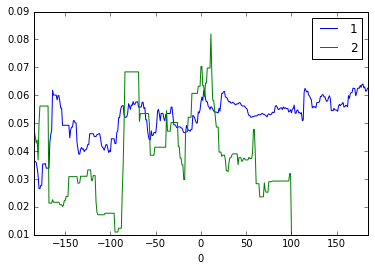

In [42]:
data.iloc[:,[0,1,2]].plot(x=0)

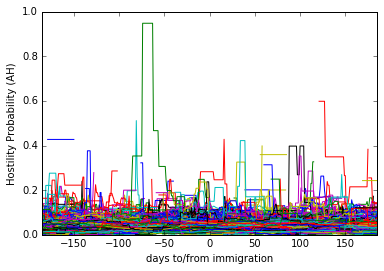

In [43]:
data.plot(x=0, legend=False)
plt.xlabel('days to/from immigration')
plt.ylabel('Hostility Probability (AH)')

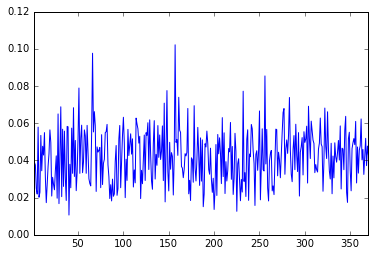

In [44]:
data.iloc[:,range(1,len(data))].mean(axis=0).plot()

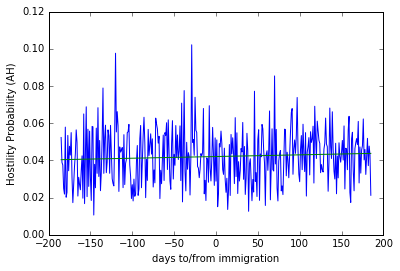

In [46]:
x = data.iloc[:,0]
y = data.iloc[:,range(1,len(data) + 1)].mean(axis=0)
plt.plot(x,y)
plt.xlabel('days to/from immigration')
plt.ylabel('Hostility Probability (AH)')
#Add trend line
z = np.polyfit(x,y,1)
p = np.poly1d(z)
plt.plot(x,p(x),"g-")